In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3, EfficientNetB0, Xception, MobileNetV2
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras import backend as K
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb



In [36]:
# Criando função para calcular as métricas
def get_metrics(y_true, y_pred):
    vn, fp, fn, vp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (vp + vn) / (vp + fp + fn + vn)
    recall = vp / (vp + fn)
    specificity = vn / (vn + fp)
    precision = vp / (vp + fp)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'specificity': specificity,
        'recall': recall,
        'precision': precision,
        'f1-score': f1,
        'kappa': kappa,
        'auc-roc': auc_roc
    }

In [37]:
# Criando função para seleção de esquema de cor 
def convert_color_scale(image, scale):
    if scale == 'hsv':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif scale == 'rgb':
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif scale == 'grayscale':
        # Converter para escala de cinza e replicar para 3 canais
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.merge([gray, gray, gray])
    elif scale == 'lab':
        return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    elif scale == 'luv':
        return cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif scale == 'xyz':
        return cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)
    elif scale == 'YcrCb':
        return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    else:
        raise ValueError("Escala de cor não suportada.")

In [38]:
# Carregamento e pré-processamento de imagens com escolha de escala de cor
def load_images(folder, color_scale, img_extensions):
    images = []
    for filename in os.listdir(folder):
        if any(filename.lower().endswith(ext) for ext in img_extensions):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Ajuste o tamanho conforme necessário

                # Converta para a escala de cor desejada
                img = convert_color_scale(img, color_scale)

                # Se a imagem estiver em escala de cinza, expanda as dimensões
                if color_scale == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Adiciona uma dimensão de canal

                images.append(img)
    return np.array(images)

In [39]:
# Defina as pastas de dados
data_dir = r"C:\Users\andre\Pictures\OvarianCancer"
normal_dir = os.path.join(data_dir, 'Non_Cancerous')
Serous= os.path.join(data_dir, 'Serous')
Mucinous = os.path.join(data_dir, 'Mucinous')
Endometrioid = os.path.join(data_dir, 'Endometri')
Clear = os.path.join(data_dir, 'Clear_Cell')
img_extensions = ['.jpg', '.jpeg', '.png']


In [40]:
# Criar um DataFrame para armazenar os resultados
columns = ['Modelo', 'Acuracia', 'Sensibilidade', 'Especificidade', 'F-Score', 'AUC-ROC']
df_metrics = pd.DataFrame(columns=columns)


In [41]:
# Carregar o modelo InceptionV3 pré-treinado
base_model = EfficientNetB0(weights='imagenet', include_top=False)     # <----------------------------------------------------------

# Extrair características usando o modelo VGG16
def extract_features(model, X):
    features = model.predict(X)
    features_flat = features.reshape((features.shape[0], -1))
    # np.savetxt("features_5Classes.csv", features_flat, delimiter=",")
    return features_flat


## <span style="color:green;">a partir daqui, complica a situação</span>

In [59]:
# Carregamento de imagens e conversão para XYZ
normal_images = load_images(normal_dir, 'grayscale',img_extensions)       
serous_images = load_images(Serous, 'grayscale',img_extensions)        
mucinous_images = load_images(Mucinous, 'grayscale',img_extensions)        
endometrioid_images = load_images(Endometrioid, 'grayscale',img_extensions)        
clear_images = load_images(Clear, 'grayscale',img_extensions)   


#      ISSO SERIA SO PRA 2 CLASSES
# Rótulos para imagens (0 para normal, 1 para câncer)
# normal_labels = np.zeros(normal_images.shape[0])
# cancer_labels = np.ones(cancer_images.shape[0])

# # Concatenar imagens e rótulos
# all_images = np.concatenate([normal_images, cancer_images], axis=0)
# all_images = extract_features(base_model, all_images)
# all_labels = np.concatenate([normal_labels, cancer_labels], axis=0)


# Rótulos para imagens (0 para normal, 1 para seroso, 2 para mucinoso, 3 para endometrioide, 4 para células claras)
y = (
    ['Non_Cancerous'] * len(normal_images) +
    ['Serous'] * len(serous_images) +
    ['Mucinous'] * len(mucinous_images) +
    ['Endometrioid'] * len(endometrioid_images) +
    ['Clear_Cell'] * len(clear_images)
)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

all_images = np.concatenate([
    normal_images,
    serous_images,
    mucinous_images,
    endometrioid_images,
    clear_images
], axis=0)
all_images = extract_features(base_model, all_images)



# Dividi em treino e teste 80/20
X_train, X_test, y_train, y_test = train_test_split(all_images, y_encoded, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0


               precision    recall  f1-score   support

   Clear_Cell       0.61      0.68      0.64        25
 Endometrioid       0.61      0.88      0.72        16
     Mucinous       0.71      0.62      0.67        16
Non_Cancerous       0.86      0.70      0.78        27
       Serous       0.77      0.62      0.69        16

     accuracy                           0.70       100
    macro avg       0.71      0.70      0.70       100
 weighted avg       0.72      0.70      0.70       100

Acurácia para Clear_Cell: 0.68
Acurácia para Endometrioid: 0.88
Acurácia para Mucinous: 0.62
Acurácia para Non_Cancerous: 0.70
Acurácia para Serous: 0.62


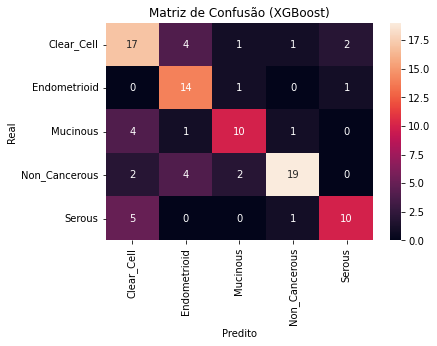

In [60]:

# svm_model = SVC(random_state=42, kernel='rbf', C=1, gamma='scale')
svm_model = xgb.XGBClassifier(
    objective='multi:softprob',  # ou 'multi:softmax' se quiser =  como saída
    num_class=5,                 # número de classes no seu problema
    eval_metric='mlogloss',     # métrica recomendada para multiclasse
    use_label_encoder=False,    # evita warning do XGBoost
    random_state=42
)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)




print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print(("=" * 60))
# Para cada classe:
for i, class_name in enumerate(le.classes_):
    idx = y_test == i
    class_acc = accuracy_score(y_test[idx],y_pred_svm[idx])
    print(f"Acurácia para {class_name}: {class_acc:.2f}")


import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão (XGBoost)')
plt.show()


               precision    recall  f1-score   support

   Clear_Cell       0.84      0.64      0.73        25
 Endometrioid       0.65      0.94      0.77        16
     Mucinous       0.64      1.00      0.78        16
Non_Cancerous       0.95      0.74      0.83        27
       Serous       0.83      0.62      0.71        16

     accuracy                           0.77       100
    macro avg       0.78      0.79      0.76       100
 weighted avg       0.81      0.77      0.77       100

Acurácia para Clear_Cell: 0.64
Acurácia para Endometrioid: 0.94
Acurácia para Mucinous: 1.00
Acurácia para Non_Cancerous: 0.74
Acurácia para Serous: 0.62


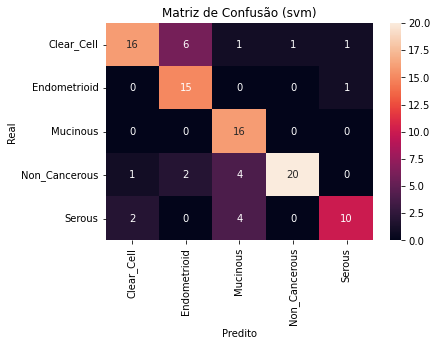

In [61]:

svm_model = SVC(random_state=42, kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)




print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


print(("=" * 60))
# Para cada classe:
for i, class_name in enumerate(le.classes_):
    idx = y_test == i
    class_acc = accuracy_score(y_test[idx],y_pred_svm[idx])
    print(f"Acurácia para {class_name}: {class_acc:.2f}")


import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão (svm)')
plt.show()

# testando somente

In [58]:

# svm_model = SVC(random_state=42, kernel='rbf', C=1, gamma='scale')
svm_model = xgb.XGBClassifier(
    objective='multi:softprob',  # ou 'multi:softmax' se quiser =  como saída
    num_class=5,                 # número de classes no seu problema
    eval_metric='mlogloss',     # métrica recomendada para multiclasse
    use_label_encoder=False,    # evita warning do XGBoost
    random_state=42
)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)



